<a href="https://colab.research.google.com/github/sayevvv/ML_Dibimbing/blob/main/portfolio_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Abdullah Shamil Basayev
Dibimbing Mini Portfolio Project

In [1]:
# ============================================
# 1. Import Libraries
# ============================================
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub
import os
import shutil

# ============================================
# 2. Download Dataset from KaggleHub
# ============================================
# Download dataset terbaru
path = kagglehub.dataset_download("yudhaislamisulistya/plants-type-datasets")
print("Original KaggleHub path:", path)

# ============================================
# 3. Pindahkan dataset ke /content/sample_data/
# ============================================

# Target folder di Colab
target_path = "/content/sample_data/plants-type-datasets"

# Jika folder target sudah ada, hapus agar tidak bentrok
if os.path.exists(target_path):
    shutil.rmtree(target_path)

# Pindahkan folder dari cache ke /content/sample_data/
shutil.move(path, target_path)

print(f"Dataset berhasil dipindahkan ke: {target_path}")
print("Isi folder setelah dipindahkan:", os.listdir(target_path))

100%|██████████| 937M/937M [00:45<00:00, 21.7MB/s]

Extracting files...


Original KaggleHub path: /root/.cache/kagglehub/datasets/yudhaislamisulistya/plants-type-datasets/versions/16
Dataset berhasil dipindahkan ke: /content/sample_data/plants-type-datasets
Isi folder setelah dipindahkan: ['split_ttv_dataset_type_of_plants']


In [3]:
# ============================================
# 3. Load Dataset (Image Classification)
# ============================================
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Path utama dataset
dataset_base_path = "/content/sample_data/plants-type-datasets/split_ttv_dataset_type_of_plants"

# Transformasi gambar (resize + normalisasi)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # semua gambar diubah ukurannya ke 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Gunakan nama folder yang benar
train_path = os.path.join(dataset_base_path, 'Train_Set_Folder')
val_path   = os.path.join(dataset_base_path, 'Validation_Set_Folder')
test_path  = os.path.join(dataset_base_path, 'Test_Set_Folder')

# Dataset
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset   = datasets.ImageFolder(root=val_path, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_path, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Info dasar
print("Classes:", train_dataset.classes)
print("Jumlah data train:", len(train_dataset))
print("Jumlah data val:", len(val_dataset))
print("Jumlah data test:", len(test_dataset))


Classes: ['aloevera', 'banana', 'bilimbi', 'cantaloupe', 'cassava', 'coconut', 'corn', 'cucumber', 'curcuma', 'eggplant', 'galangal', 'ginger', 'guava', 'kale', 'longbeans', 'mango', 'melon', 'orange', 'paddy', 'papaya', 'peper chili', 'pineapple', 'pomelo', 'shallot', 'soybeans', 'spinach', 'sweet potatoes', 'tobacco', 'waterapple', 'watermelon']
Jumlah data train: 23972
Jumlah data val: 3030
Jumlah data test: 2998


In [4]:
print("Isi folder utama:", os.listdir(dataset_base_path))
print("Isi Train_Set_Folder:", os.listdir(train_path)[:5])  # tampilkan 5 folder pertama


Isi folder utama: ['Train_Set_Folder', 'Validation_Set_Folder', 'Test_Set_Folder']
Isi Train_Set_Folder: ['tobacco', 'pineapple', 'kale', 'longbeans', 'mango']


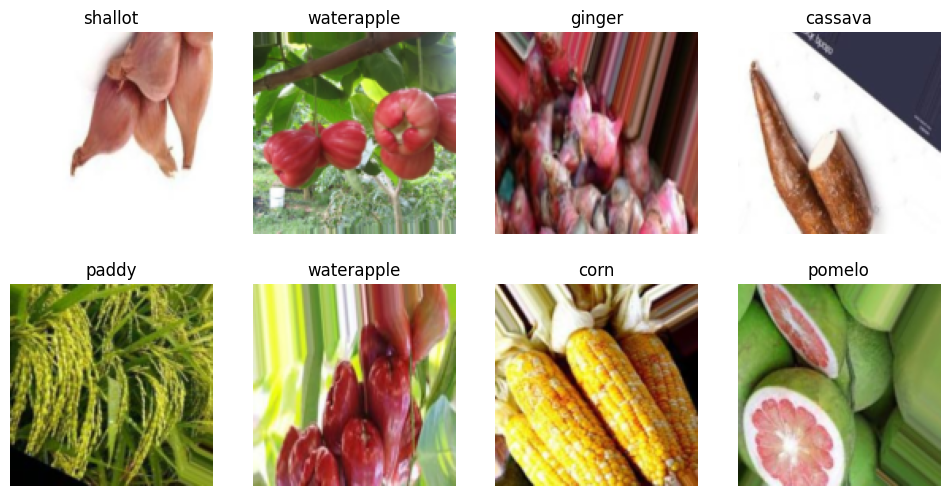

In [5]:
#Visualisasi Sample Data
import matplotlib.pyplot as plt
import numpy as np

# Fungsi untuk menampilkan gambar
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# Ambil batch sample
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Tampilkan 8 sample pertama
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(images[i], title=train_dataset.classes[labels[i]])
plt.show()


In [27]:
#Build CNN Model
import torch.nn as nn
import torch.nn.functional as F

class PlantClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Model instance
num_classes = len(train_dataset.classes)
model = PlantClassifierCNN(num_classes)

print(model)


PlantClassifierCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=30, bias=True)
)
Model moved to device: cuda


In [35]:
from torch.utils.data import Subset

# Tentukan jumlah sample yang dipakai (Menggunakan seluruh dataset)
# train_subset_size = 500 # Komentari atau hapus baris ini
# val_subset_size = 100   # Komentari atau hapus baris ini

# Buat subset dataset (Tidak lagi menggunakan subset, gunakan dataset penuh)
# small_train_dataset = Subset(train_dataset, range(train_subset_size)) # Komentari atau hapus baris ini
# small_val_dataset = Subset(val_dataset, range(val_subset_size))     # Komentari atau hapus baris ini

# DataLoader (Gunakan dataset penuh)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"Jumlah gambar yang dipakai untuk training: {len(train_dataset)}")
print(f"Jumlah gambar yang dipakai untuk validation: {len(val_dataset)}")

Jumlah gambar yang dipakai untuk training: 23972
Jumlah gambar yang dipakai untuk validation: 3030


In [23]:
import torch.optim as optim
import torch.nn as nn

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
from torch.cuda.amp import GradScaler, autocast # Keep import in case user wants to re-enable

epochs = 5
# scaler = GradScaler() # Comment out or remove scaler usage

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        # with autocast():  # Mixed precision - comment out or remove this block
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # scaler.scale(loss).backward() # Comment out or remove scaler usage
        # scaler.step(optimizer) # Comment out or remove scaler usage
        # scaler.update() # Comment out or remove scaler usage

        loss.backward() # Use standard backward pass
        optimizer.step() # Use standard optimizer step


        running_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}")

    # Simpan checkpoint
    torch.save(model.state_dict(), f"/content/sample_data/plant_model_epoch{epoch+1}.pth")

Epoch 1/5, Train Loss: 3.4026, Val Loss: 3.4030
Epoch 2/5, Train Loss: 3.4025, Val Loss: 3.4030
Epoch 3/5, Train Loss: 3.4025, Val Loss: 3.4030
Epoch 4/5, Train Loss: 3.4025, Val Loss: 3.4030
Epoch 5/5, Train Loss: 3.4025, Val Loss: 3.4030


=== Classification Report ===
                precision    recall  f1-score   support

      aloevera       0.00      0.00      0.00     100.0
        banana       0.00      0.00      0.00       0.0
       bilimbi       0.00      0.00      0.00       0.0
    cantaloupe       0.00      0.00      0.00       0.0
       cassava       0.00      0.00      0.00       0.0
       coconut       0.00      0.00      0.00       0.0
          corn       0.00      0.00      0.00       0.0
      cucumber       0.00      0.00      0.00       0.0
       curcuma       0.00      0.00      0.00       0.0
      eggplant       0.00      0.00      0.00       0.0
      galangal       0.00      0.00      0.00       0.0
        ginger       0.00      0.00      0.00       0.0
         guava       0.00      0.00      0.00       0.0
          kale       0.00      0.00      0.00       0.0
     longbeans       0.00      0.00      0.00       0.0
         mango       0.00      0.00      0.00       0.0
         melon   

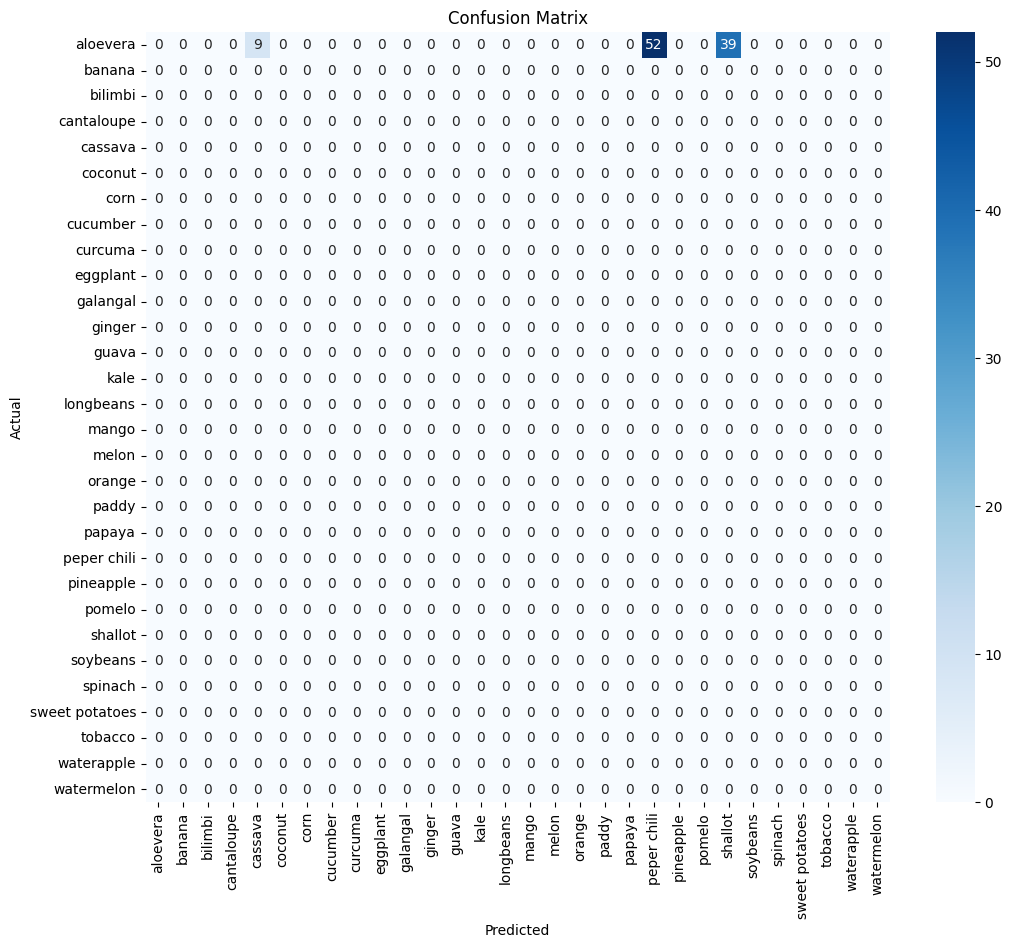

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Subset, DataLoader

# Assuming test_dataset is already defined from previous cells
# If you want to use a subset for faster evaluation, uncomment and adjust
# test_subset_size = 100
# small_test_dataset = Subset(test_dataset, range(test_subset_size))
# test_loader = DataLoader(small_test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# If you want to use the full test dataset, make sure to use the original test_loader
# Assuming test_loader is already defined from previous cells for the full test dataset

# Evaluation model
model.eval()
all_preds = []
all_labels = []

# Ensure device is defined (should be from a previous cell)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device) # Ensure model is on the correct device

with torch.no_grad():
    for inputs, labels in test_loader:
        # Ensure inputs and labels are on the correct device
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the index of the class with the highest probability
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get all possible labels from the training dataset for consistent reporting
# Assuming train_dataset is defined from previous cells
all_possible_labels = np.arange(len(train_dataset.classes))
target_names = train_dataset.classes

# --- Classification Report ---
print("=== Classification Report ===")
try:
    print(classification_report(all_labels, all_preds, target_names=target_names, labels=all_possible_labels, zero_division=0))
except ValueError as e:
    print(f"Could not generate classification report: {e}")
    if not all_labels and not all_preds:
        print("No labels or predictions were recorded during evaluation.")


# --- Confusion Matrix ---
# Use all possible labels for the confusion matrix as well
cm = confusion_matrix(all_labels, all_preds, labels=all_possible_labels)

plt.figure(figsize=(12, 10)) # Increased figure size for better readability with many classes
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

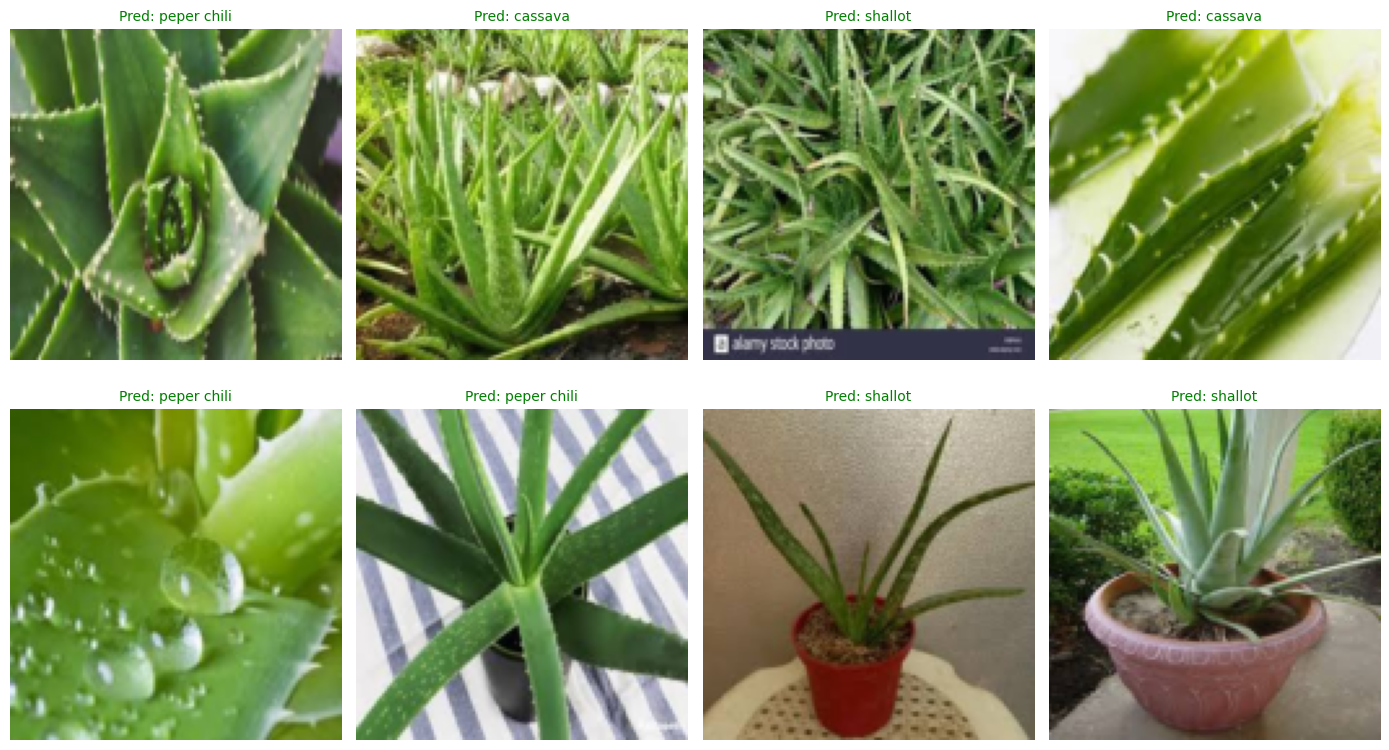

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Fungsi untuk menampilkan gambar
def imshow(inp, title=None):
    inp = inp / 2 + 0.5  # unnormalize jika normalize(mean=0.5, std=0.5)
    npimg = inp.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Ambil batch dari test_loader
model.eval()
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Forward pass
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Tampilkan 8 gambar pertama beserta prediksi
plt.figure(figsize=(14, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    imshow(images[i].cpu())
    ax.set_title(f"Pred: {train_dataset.classes[preds[i]]}",
                 fontsize=10,
                 color="red" if preds[i] == labels[i] else "green")
plt.tight_layout()
plt.show()